In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats

from sklearn.metrics import roc_auc_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import mutual_info_classif

In [2]:
X_train = pd.read_csv('input/X_train.csv')
y_train = pd.read_csv('input/y_train.csv')
X_test = pd.read_csv('input/X_test.csv')
y_test = pd.read_csv('input/y_test.csv')

In [3]:
del y_test['Unnamed: 0']
del y_train['Unnamed: 0']
del X_train['Unnamed: 0']
del X_test['Unnamed: 0']

In [4]:
from collections import defaultdict
models=defaultdict(list)

### Glasanje - Voting

In [5]:
model_tree = DecisionTreeClassifier()
model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()

#### Kreiranje modela sa default parametrima

In [6]:
model_voting = VotingClassifier(estimators=[('lr', model_lr),
                                    ('nb', model_tree),
                                    ('knn', model_knn)], voting = "soft")
model_voting.fit(X_train, y_train)
score_1=cross_val_score(model_voting, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.815651054221345

In [7]:
score_3=roc_auc_score(y_test, model_voting.predict(X_test))
score_3

0.7552527700043228

In [8]:
models['Voting default params']=[score_1, score_3]

#### Podesavanje parametara

In [9]:
# Decision Tree
params = {"min_samples_leaf": np.linspace(1,30,15,dtype = int),"max_depth": np.linspace(3,30,15,dtype = int)}
n_iter_search = 100
random_search = RandomizedSearchCV(model_tree, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='roc_auc',random_state=42)
random_search.fit(X_train,y_train)
print('Best param: ', random_search.best_params_)

Best param:  {'min_samples_leaf': 30, 'max_depth': 14}


In [10]:
model_tree = DecisionTreeClassifier(min_samples_leaf = 30, max_depth = 14)

In [11]:
params = {"n_neighbors": np.linspace(2,20,10,dtype = int),"weights": ['uniform','distance']}
n_iter_search = 100
random_search = RandomizedSearchCV(model_knn, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='roc_auc', random_state=42)
random_search.fit(X_train,y_train)
print('Best param: ', random_search.best_params_)

Best param:  {'weights': 'distance', 'n_neighbors': 20}


In [ ]:
model_knn = KNeighborsClassifier(weights='distance', n_neighbors = 20)

In [13]:
params = {"penalty": ['l1', 'l2'], "C": scipy.stats.uniform(0.0001,2)} 
n_iter_search = 100
random_search = RandomizedSearchCV(model_lr, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='roc_auc', random_state=42)
random_search.fit(X_train,y_train)
print('Best param: ', random_search.best_params_)

Best param:  {'C': 0.32254257450800883, 'penalty': 'l2'}


In [14]:
model_lr = LogisticRegression(C =  0.32254257450800883, penalty = 'l2')

In [15]:
model_voting = VotingClassifier(estimators=[('lr', model_lr),
                                    ('nb', model_tree),
                                    ('knn', model_knn)], voting = "soft")
model_voting.fit(X_train, y_train)
score_1=cross_val_score(model_voting, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8401411215939936

In [16]:
score_3=roc_auc_score(y_test, model_voting.predict(X_test))
score_3

0.7853986076035766

In [17]:
models['Voting optimized params']=[score_1, score_3]

### Random Forest

In [18]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_forest.fit(X_train, y_train)
score_1=cross_val_score(model_forest, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8416745195501398

In [19]:
score_3=roc_auc_score(y_test, model_forest.predict(X_test))
score_3

0.7929834141014265

In [20]:
models['RF default params']=[score_1, score_3]

<AxesSubplot:ylabel='att'>

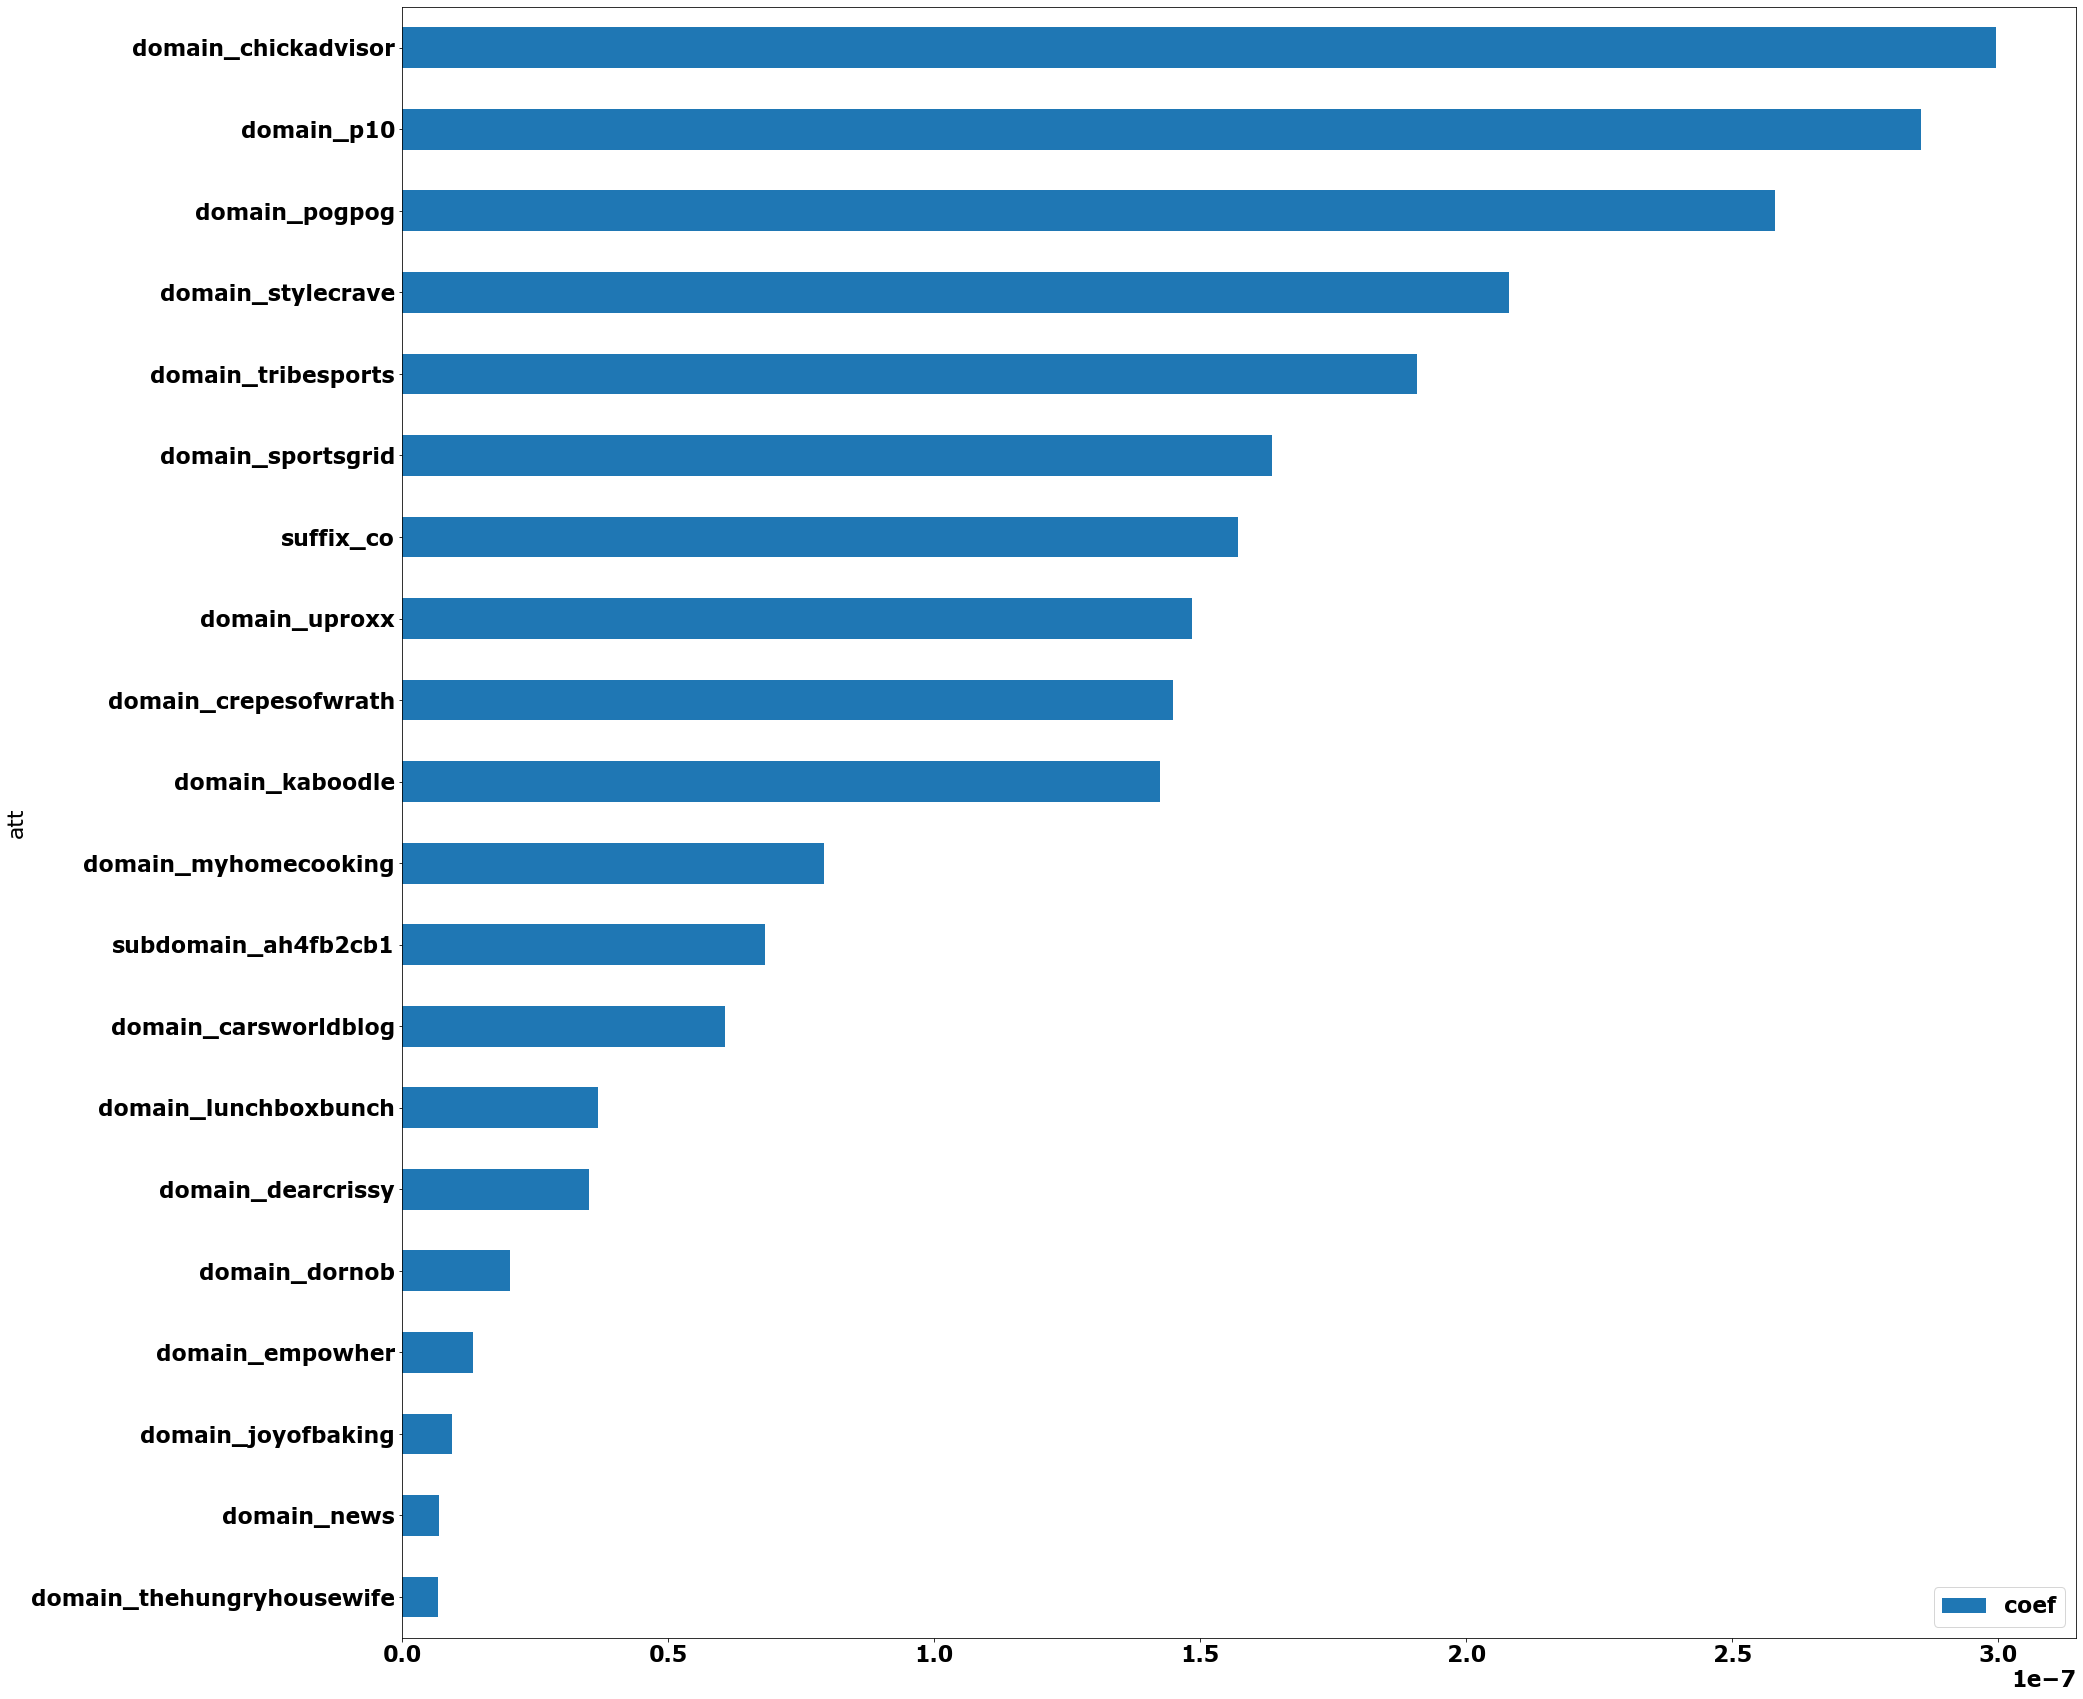

In [21]:
import matplotlib
%matplotlib inline
font = {'family' : 'Verdana',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)
coefs = pd.DataFrame({'att':X_train.columns, 'coef':model_forest.feature_importances_}).sort_values(by='coef',ascending=True).replace(0,np.nan).dropna()[:20]
coefs.plot.barh(x='att',y='coef',figsize=(30, 30))

In [22]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=42,oob_score=True)
model_forest.fit(X_train, y_train)

model_forest.oob_score_

0.7739567233384853

### Stacking

#### Kreiranje modela sa default parametrima

In [23]:
model_tree = DecisionTreeClassifier()
model_lr = LogisticRegression()
model_knn = KNeighborsClassifier()

model_stacking = StackingClassifier(classifiers=[model_tree, model_lr, model_knn], meta_classifier = LogisticRegression())
model_stacking.fit(X_train, y_train)
score_1=cross_val_score(model_stacking, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.7950414656992542

In [24]:
score_3=roc_auc_score(y_test, model_stacking.predict(X_test))
score_3

0.7027108502263782

In [25]:
models['Stacking default params']=[score_1, score_3]

In [26]:
# Prosledjivanje ulaznih atributa meta klasifikatoru
model_stacking = StackingClassifier(classifiers=[model_tree, model_lr, model_knn], 
                                    meta_classifier = LogisticRegression(), 
                                    use_features_in_secondary=True)
model_stacking.fit(X_train,y_train)
score_1=cross_val_score(model_stacking, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8044451583769398

In [27]:
score_3=roc_auc_score(y_test, model_stacking.predict(X_test))
score_3

0.7022956339726526

In [28]:
models['Stacking with use_features_in_secondary']=[score_1, score_3]

#### Kreiranje modela sa podesenim parametrima

In [31]:
model_tree = DecisionTreeClassifier(min_samples_leaf = 30, max_depth = 14)
model_knn = KNeighborsClassifier(weights='distance', n_neighbors = 20)
model_lr = LogisticRegression(C =0.32254257450800883, penalty = 'l2')

In [32]:
model_stacking = StackingClassifier(classifiers=[model_tree, model_lr, model_knn], 
                                    meta_classifier = LogisticRegression(), 
                                    use_features_in_secondary=True)

model_stacking.fit(X_train,y_train)
score_1=cross_val_score(model_stacking, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.827021400944054

In [33]:
score_3=roc_auc_score(y_test, model_stacking.predict(X_test))
score_3

0.7252036266011421

In [34]:
models['Stacking optimized params']=[score_1, score_3]

### Bagging

In [35]:
# BAGGING sa decision tree
model_tree = DecisionTreeClassifier()
model_bagging = BaggingClassifier(base_estimator=model_tree, bootstrap=True, random_state=42)
model_bagging.fit(X_train, y_train)
score_1=cross_val_score(model_bagging, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8123033961868726

In [36]:
score_3=roc_auc_score(y_test, model_bagging.predict(X_test))
score_3

0.7684998748663345

In [37]:
models['Bagging DT default params']=[score_1, score_3]

In [38]:
# BAGGING sa log.reg.
model_lr = LogisticRegression()
model_bagging = BaggingClassifier(base_estimator=model_lr, bootstrap=True, random_state=42)
model_bagging.fit(X_train, y_train)
score_1=cross_val_score(model_bagging, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8332293954816313

In [40]:
score_3=roc_auc_score(y_test, model_bagging.predict(X_test))
score_3

0.7869343389529725

In [41]:
models['Bagging LR default params']=[score_1, score_3]

In [42]:
# BAGGING sa knn
model_knn = KNeighborsClassifier()
model_bagging = BaggingClassifier(base_estimator=model_knn, bootstrap=True, random_state=42)
model_bagging.fit(X_train, y_train)
score_1=cross_val_score(model_bagging, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.7755643703017336

In [43]:
score_3=roc_auc_score(y_test, model_bagging.predict(X_test))
score_3

0.7121584419721066

In [44]:
models['Bagging KNN default params']=[score_1, score_3]

#### Model sa podesenim parametrima

In [45]:
DecisionTreeClassifier(min_samples_leaf = 30, max_depth = 14)
model_knn = KNeighborsClassifier(weights='distance', n_neighbors = 20)
model_lr = LogisticRegression(C =0.32254257450800883, penalty = 'l2')

In [46]:
# BAGGING sa decision tree
model_bagging = BaggingClassifier(base_estimator=model_tree, bootstrap=True, random_state=42)
model_bagging.fit(X_train, y_train)
score_1=cross_val_score(model_bagging, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8123033961868726

In [47]:
score_3=roc_auc_score(y_test, model_bagging.predict(X_test))
score_3

0.7684998748663345

In [48]:
models['Bagging DT optimized params']=[score_1, score_3]

Rezultat se nakon podesavanja parametara znatno povecao kod bagginga koji za osnovu ima model_tree

In [49]:
# BAGGING sa log.reg.
model_bagging = BaggingClassifier(base_estimator=model_lr, bootstrap=True, random_state=42)
model_bagging.fit(X_train, y_train)
score_1=cross_val_score(model_bagging, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8336753072528673

In [50]:
score_3=roc_auc_score(y_test, model_bagging.predict(X_test))
score_3

0.7857597888653789

In [51]:
models['Bagging LR optimized params']=[score_1, score_3]

In [52]:
#Bagging sa knn
model_bagging = BaggingClassifier(base_estimator=model_knn, bootstrap=True, random_state=42)
model_bagging.fit(X_train, y_train)
score_1=cross_val_score(model_bagging, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.7908374234974158

In [53]:
score_3=roc_auc_score(y_test, model_bagging.predict(X_test))
score_3

0.7244158532978409

In [54]:
models['Bagging KNN optimized params']=[score_1, score_3]

Rezultat za knn se blago poboljsao u odnosu na model bez podesavanja parametara

### Boosting algoritmi

#### AdaBoost

In [55]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier(n_estimators=250, random_state=42)
model.fit(X_train,y_train)
score_1=cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8152599650565602

In [56]:
score_3 = roc_auc_score(y_test, model.predict(X_test))
score_3

0.7727515755466066

In [57]:
models['AdaBoost']=[score_1, score_3]

#### GradientBoostingClassifier

In [58]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=150,criterion='friedman_mse',max_depth=4, learning_rate=0.05, random_state=42)
model.fit(X_train,y_train)
score_1=cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8401890048546766

In [59]:
score_3=roc_auc_score(y_test, model.predict(X_test))
score_3

0.7903783587013401

In [60]:
models['GradientBoostingClassifier']=[score_1, score_3]

In [ ]:
#!pip install lightgbm

#### LGBMClassifier

In [61]:
import lightgbm as lgb
model = lgb.LGBMClassifier(boosting_type='goss',random_state=42, n_estimators=200, learning_rate=0.01, objective='binary')
model.fit(X_train,y_train)
score_1=cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8404572478243372

In [62]:
score_3=roc_auc_score(y_test, model.predict(X_test))
score_3

0.788606579755648

In [63]:
#!pip install xgboost

In [64]:
models['LGBMClassifier']=[score_1, score_3]

#### XGBClassifier

In [65]:
from xgboost import XGBClassifier
model=XGBClassifier(max_depth=10, learning_rate=0.03,seed=42,gamma=0.05, n_estimators=200, silent=1)
model.fit(X_train,y_train)
score_1=cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc').mean()
score_1

[20:08:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[20:08:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:08:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to

0.8463668846676878

In [66]:
score_3=roc_auc_score(y_test, model.predict(X_test))
score_3

0.7999681477942349

In [67]:
models['XGBClassifier']=[score_1, score_3]

### Selekcija atributa

#### K-Best

In [68]:
selection = SelectKBest(k=100, score_func=mutual_info_classif)
selection.fit(X_train, y_train)
#selection.get_support()

SelectKBest(k=100,
            score_func=<function mutual_info_classif at 0x0000022AFD161310>)

In [69]:
X_train_reduced = X_train.loc[:, selection.get_support()]
X_test_reduced = X_test.loc[:, selection.get_support()]

In [70]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_forest.fit(X_train_reduced, y_train)
score_1=cross_val_score(model_forest, X_train_reduced, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8243219119691435

In [71]:
score_3=roc_auc_score(y_test, model_forest.predict(X_test_reduced))
score_3

0.7732919254658386

In [72]:
models['RF after SelectKBest']=[score_1, score_3]

Probala sam kod bagginga takodje se ne poboljsava

#### VarianceThreshold

In [73]:
from sklearn.feature_selection import VarianceThreshold

In [74]:
def variance_threshold_selector(data, threshold=0.01):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [75]:
a=variance_threshold_selector(X_train)

X_train_reduced=a
X_test_reduced=X_test[a.columns]

In [76]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_forest.fit(X_train_reduced, y_train)
score_1=cross_val_score(model_forest, X_train_reduced, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8430627396415297

In [77]:
score_3=roc_auc_score(y_test, model_forest.predict(X_test_reduced))
score_3

0.791225854890451

In [78]:
models['RF after VarianceThreshold']=[score_1, score_3]

#### RFECV

In [84]:
model_rf = RFECV(estimator=model_tree, min_features_to_select=500, cv=5, step=2, scoring='roc_auc')
model_rf.fit(X_train, y_train)

model_rf.get_support()

array([ True,  True,  True, ...,  True,  True,  True])

In [85]:
X_train_reduced = X_train.loc[:, model_rf.get_support()]
X_test_reduced = X_test.loc[:, model_rf.get_support()]

In [86]:
model_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_forest.fit(X_train_reduced, y_train)
score_1=cross_val_score(model_forest, X_train_reduced, y_train, cv=10, scoring='roc_auc').mean()
score_1

0.8425620083603519

In [87]:
score_3=roc_auc_score(y_test, model_forest.predict(X_test_reduced))
score_3

0.7861579414374447

In [88]:
models['RF after RFECV']=[score_1, score_3]

### Čuvanje rezultata

In [89]:
all_models=pd.DataFrame(models)
all_models=all_models.T
all_models.columns=['ROC-AUC CV train','ROC-AUC test']
all_models=np.round(all_models,3)
all_models.sort_values(by='ROC-AUC test',ascending=False)

ROC-AUC CV train  ROC-AUC test
XGBClassifier                                       0.846         0.800
RF default params                                   0.842         0.793
RF after VarianceThreshold                          0.843         0.791
GradientBoostingClassifier                          0.840         0.790
LGBMClassifier                                      0.840         0.789
Bagging LR default params                           0.833         0.787
RF after RFECV                                      0.843         0.786
Bagging LR optimized params                         0.834         0.786
Voting optimized params                             0.840         0.785
AdaBoost                                            0.815         0.773
RF after SelectKBest                                0.824         0.773
Bagging DT optimized params                         0.812         0.768
Bagging DT default params                           0.812         0.768
Voting default params                               0.816         0.755
Stacking optimized params                           0.827         0.725
Bagging KNN optimized params                        0.791         0.724
Bagging KNN default params                          0.776         0.712
Stacking default params                             0.795         0.703
Stacking with use_features_in_secondary             0.804         0.702

In [82]:
#najbolji model
model=XGBClassifier(max_depth=10, learning_rate=0.03,seed=42,gamma=0.05, n_estimators=200, silent=1)
model.fit(X_train,y_train)
with open('output/model.pcl', 'wb') as picklefile:
    pickle.dump(model, picklefile)

[21:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:51:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
